# Обучение GNN-модели на датасете графов

In [1]:
%load_ext autoreload
%autoreload 2

from src.data.hydrodataset import HydroDataset

import torch
torch.autograd.set_detect_anomaly(True)

from src.models.gnnstableprocessor import GNNStableProcessor
from src.visualization.visualize import visualize_graph
from src.models.train_model import HydraulicsLoss, MultiHydraulicsLoss

from torch_geometric.nn import summary
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [3]:
dataset = HydroDataset(root="/tmp/hydro")
train_ds = dataset
print("Dataset length:", len(train_ds))

Dataset length: 300


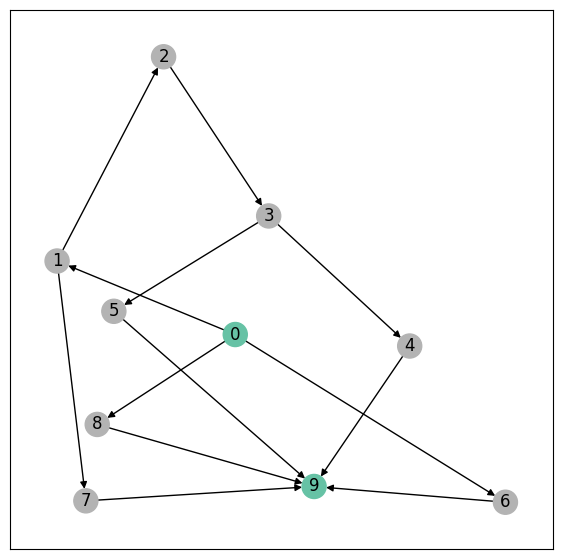

In [4]:
G = to_networkx(train_ds[1], to_undirected=False)
visualize_graph(G, color=dataset[0].x[..., 1] == 0);

In [5]:
loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [6]:
model = GNNStableProcessor(out_channels=1, 
                     num_edge_features=dataset.num_edge_features, 
                     latent_dim=64, 
                     num_convs=20, 
                     convs_hidden_layers=[64],
                     alpha_update_x=0.1,
                     aggr="mean",
                     device=device).to(device)

print(model)
print(next(model.parameters()).device)

GNNStableProcessor(
  (convs): ModuleList(
    (0-19): 20 x GNNSConv(aggr=mean, latent_dim=64, alpha=0.1, hidden_layers=[64])
  )
  (final): Linear(in_features=64, out_features=1, bias=True)
  (balance_conv): BalanceConv()
  (decoders): ModuleList(
    (0-19): 20 x Linear(in_features=64, out_features=1, bias=True)
  )
)
cuda:0


In [7]:
criterion = MultiHydraulicsLoss(gamma=0.75, device=device).to(device)
info_criterion = HydraulicsLoss(name='Info loss').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [8]:
def train(pretrain_data=None):
  model.train()

  total_loss = 0
  for data in loader if pretrain_data is None else [pretrain_data]:
    data = data.to(device)
    optimizer.zero_grad()
    P, _, imbalance_list = model(data)
    loss = criterion(data, P, imbalance_list)
    # Вычисление информационного loss на последнем слое GNN
    info_loss = info_criterion(data, P, imbalance_list[-1, ...].unsqueeze(0))
    # Отслеживание loss на последнем слое н/с 
    total_loss += info_loss.item() * data.num_graphs if pretrain_data is None else info_loss.item()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  
    optimizer.step()

  total_loss = total_loss / len(loader.dataset) if pretrain_data is None else total_loss

  return total_loss

In [9]:
# # pretrain the model
# for epoch in range(10000):
#   loss = train(train_ds[0])
#   if (epoch % 10 == 0):
#     print(f'Pretraining epoch: {epoch:03d}, Loss: {loss:.4f}')   

In [11]:
# train
losses = []
for epoch in range(10000):
  loss = train()
  losses.append(loss)

  if (epoch % 10 == 0):
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}') 

Epoch: 000, Loss: 9.7728


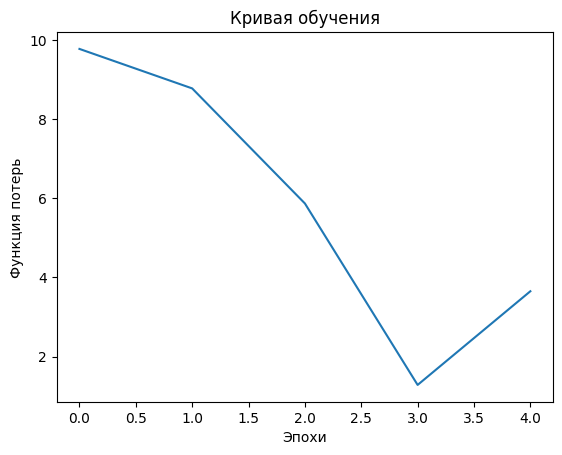

In [12]:
plt.plot(losses)
plt.title('Кривая обучения')
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь')
plt.show()

# Тестирование модели

In [13]:
edge_index = torch.tensor([
  [0, 1, 2],
  [1, 2, 3]
], dtype=torch.long)

# Структура данных атрибутов вершин графа:
# Расход газа потребителя в узле, млн м3/сут; Давление газа, МПа
x = torch.tensor([[0, 7.4], [0.0, 0], [0, 0], [0, 5.4]], dtype=torch.float32)

# Структура данных атрибутов дуг графа:
# Протяженность, км; Внутренний диаметр трубы, мм
edge_attr = torch.tensor([
  [38, 1400],
  [40, 1400],
  [43, 1400]
])

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr).to(device)

In [14]:
%%timeit
# %%timeit 
# Attention: При выводе значений давления краевые значения не выводятся, но учитываются в расчете
P, flows, imbalance = model(data)
print(f'{P=}')
print(f'{flows=}')
print(f'{imbalance=}')

P=tensor([[8.4965],
        [7.1197],
        [6.8372],
        [5.1429]], device='cuda:0', grad_fn=<ReluBackward0>)
flows=tensor([[[  0.0000],
         [144.8085],
         [  1.0601],
         [ 76.8222]],

        [[  0.0000],
         [118.6699],
         [ 64.1487],
         [ 90.3376]],

        [[  0.0000],
         [112.2852],
         [ 65.2217],
         [ 96.6171]],

        [[  0.0000],
         [104.5580],
         [ 68.8179],
         [101.8196]],

        [[  0.0000],
         [104.5288],
         [ 68.9158],
         [101.7845]],

        [[  0.0000],
         [105.2566],
         [ 68.7344],
         [101.2343]],

        [[  0.0000],
         [104.9253],
         [ 68.7909],
         [101.5022]],

        [[  0.0000],
         [ 67.1364],
         [ 63.5664],
         [129.1972]],

        [[  0.0000],
         [ 65.5549],
         [ 63.6426],
         [129.8782]],

        [[  0.0000],
         [ 66.9249],
         [ 63.6111],
         [129.2736]],

        [[  0.000

In [15]:
import torch_geometric
compiled = torch_geometric.compile(model)
torch._dynamo.config.suppress_errors = True

/home/ab/anaconda3/envs/nfsolver/lib/python3.10/site-packages/torch_geometric/compile.py:28: UserWarning: Could not convert the 'model' into a jittable version. As such, 'torch.compile' may currently fail to correctly optimize your model. 'MessagePassing.jittable()' reported the following error: TorchScript support requires the definition of the types passed to `propagate()`. Please specify them via

propagate_type = {"arg1": type1, "arg2": type2, ... }

or via

# propagate_type: (arg1: type1, arg2: type2, ...)

inside the `MessagePassing` module.
  warnings.warn(JIT_WARNING.format(error=e))


In [16]:
%%timeit
P, flows, imbalance = compiled(data)

[2023-10-01 23:28:37,801] torch._dynamo.convert_frame: [ERROR] WON'T CONVERT _collect /home/ab/anaconda3/envs/nfsolver/lib/python3.10/site-packages/torch_geometric/nn/conv/message_passing.py line 317 
due to: 
Traceback (most recent call last):
  File "/home/ab/anaconda3/envs/nfsolver/lib/python3.10/site-packages/torch/_inductor/scheduler.py", line 1118, in create_backend
    raise RuntimeError(
RuntimeError: Found NVIDIA GeForce GTX 1070 which is too old to be supported by the triton GPU compiler, which is used as the backend. Triton only supports devices of CUDA Capability >= 7.0, but your device is of CUDA capability 6.1

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/ab/anaconda3/envs/nfsolver/lib/python3.10/site-packages/torch/_dynamo/output_graph.py", line 675, in call_user_compiler
    raise BackendCompilerFailed(self.compiler_fn, e) from e
torch._dynamo.exc.BackendCompilerFailed: debug_wrapper raised Runtim

712 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
